# Import the Library

In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    AutoConfig,
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score
from tokenizers import AddedToken

# Suppress warnings for cleaner output
warnings.simplefilter('ignore')

# Set GPU devices
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

2025-03-11 11:27:41.872650: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-11 11:27:41.872794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-11 11:27:42.049486: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set random seeds for reproducibility
def set_random_seed(seed):
    import random
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [3]:
# Configuration
class Config:
    # Model training settings
    use_regression = True  # True for regression, False for classification
    version = 1  # Version number for saved models
    
    # Path settings
    train_path = '/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv'
    test_path = '/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv'
    submission_path = '/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv'
    model_path = "/kaggle/input/huggingfacedebertav3variants/deberta-v3-small"
    output_dir = f'essay_scoring_model_v{version}'
    
    # Model hyperparameters
    num_folds = 5
    seed = 42
    max_length = 1024
    learning_rate = 1e-5
    train_batch_size = 4
    eval_batch_size = 8
    train_epochs = 4
    weight_decay = 0.01
    warmup_ratio = 0.0
    num_classes = 6  # 6 possible scores (0-5)

In [4]:
# Data Tokenization class
class EssayTokenizer:
    def __init__(self, train_data, validation_data, tokenizer):
        self.tokenizer = tokenizer
        self.train_data = train_data
        self.validation_data = validation_data
        
    def create_dataset(self, dataframe):
        return Dataset.from_dict({
            'essay_id': dataframe['essay_id'].tolist(),
            'full_text': dataframe['full_text'].tolist(),
            'label': dataframe['label'].tolist(),
        })
        
    def tokenize_texts(self, examples):
        return self.tokenizer(
            examples['full_text'], 
            truncation=True, 
            max_length=Config.max_length
        )
    
    def process(self):
        train_dataset = self.create_dataset(self.train_data)
        valid_dataset = self.create_dataset(self.validation_data)
        
        tokenized_train = train_dataset.map(
            self.tokenize_texts, batched=True
        )
        tokenized_valid = valid_dataset.map(
            self.tokenize_texts, batched=True
        )
        
        return tokenized_train, tokenized_valid, self.tokenizer

In [5]:
# Metrics calculation for regression
def calculate_metrics_regression(eval_pred):
    predictions, labels = eval_pred
    # Clip predictions between 0-5 and round to nearest integer for QWK
    qwk = cohen_kappa_score(
        labels, 
        predictions.clip(0, 5).round(0), 
        weights='quadratic'
    )
    return {'qwk': qwk}

# Metrics calculation for classification
def calculate_metrics_classification(eval_pred):
    predictions, labels = eval_pred
    # Get the class with highest probability and calculate QWK
    qwk = cohen_kappa_score(
        labels, 
        predictions.argmax(-1), 
        weights='quadratic'
    )
    return {'qwk': qwk}

In [6]:
# Load and prepare training data
train_data = pd.read_csv(Config.train_path)
# Convert scores (1-6) to labels (0-5)
train_data['label'] = train_data['score'].apply(lambda x: x - 1)

# Set label type based on the model approach
if Config.use_regression:
    train_data["label"] = train_data["label"].astype('float32')
else:
    train_data["label"] = train_data["label"].astype('int32')
    
# Load and predict on test data
test_data = pd.read_csv(Config.test_path)
test_data['label'] = 0.0  # Placeholder label

# Create submission file
submission = pd.read_csv(Config.submission_path)

In [7]:
# Create stratified folds for cross-validation
skf = StratifiedKFold(n_splits=Config.num_folds, shuffle=True, random_state=Config.seed)
for fold_idx, (_, val_index) in enumerate(skf.split(train_data, train_data["score"])):
    train_data.loc[val_index, "fold"] = fold_idx

In [8]:
set_random_seed(Config.seed)
# Define training arguments
training_args = TrainingArguments(
    output_dir=Config.output_dir,
    fp16=True,  # Use mixed precision training
    learning_rate=Config.learning_rate,
    per_device_train_batch_size=Config.train_batch_size,
    per_device_eval_batch_size=Config.eval_batch_size,
    num_train_epochs=Config.train_epochs,
    weight_decay=Config.weight_decay,
    evaluation_strategy='epoch',
    metric_for_best_model='qwk',
    save_strategy='epoch',
    save_total_limit=1,
    load_best_model_at_end=True,
    report_to='none',
    warmup_ratio=Config.warmup_ratio,
    lr_scheduler_type='linear',
    optim='adamw_torch',
    logging_first_step=True,
)


===== Training Fold 1/5 =====


Map:   0%|          | 0/13845 [00:00<?, ? examples/s]

Map:   0%|          | 0/3462 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingfacedebertav3variants/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Qwk
1,0.361100,0.308533,0.780148
2,0.296200,0.291314,0.813240
3,0.242000,0.294072,0.817376
4,0.191500,0.286357,0.826993


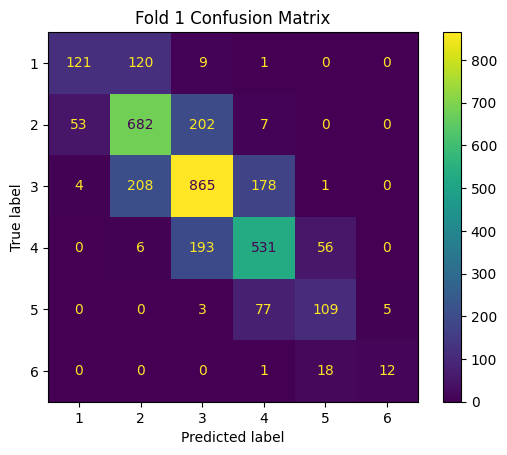


===== Training Fold 2/5 =====


Map:   0%|          | 0/13845 [00:00<?, ? examples/s]

Map:   0%|          | 0/3462 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingfacedebertav3variants/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Qwk
1,0.358500,0.459473,0.758551
2,0.305600,0.287193,0.825786
3,0.256800,0.280480,0.817984
4,0.208500,0.277126,0.831958


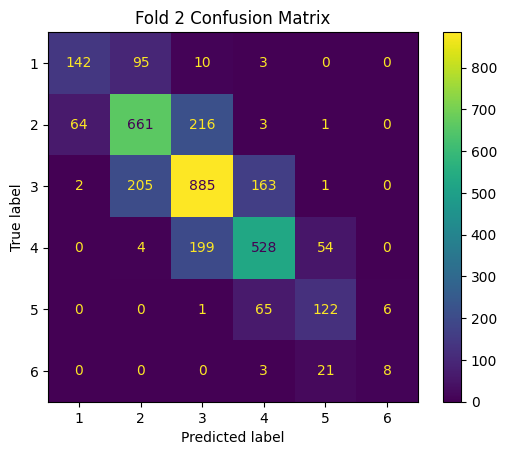


===== Training Fold 3/5 =====


Map:   0%|          | 0/13846 [00:00<?, ? examples/s]

Map:   0%|          | 0/3461 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingfacedebertav3variants/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Qwk
1,0.355100,0.369103,0.785677
2,0.298600,0.300831,0.816381
3,0.247000,0.307904,0.822745
4,0.199700,0.299085,0.813279


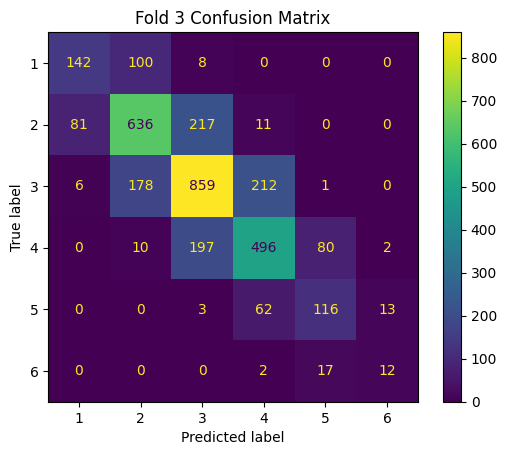


===== Training Fold 4/5 =====


Map:   0%|          | 0/13846 [00:00<?, ? examples/s]

Map:   0%|          | 0/3461 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingfacedebertav3variants/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Qwk
1,0.346100,0.368295,0.780556
2,0.278200,0.302279,0.818403
3,0.247500,0.295942,0.807504
4,0.203000,0.295714,0.820833


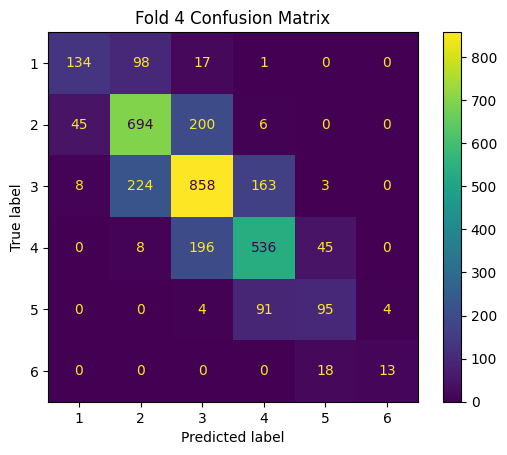


===== Training Fold 5/5 =====


Map:   0%|          | 0/13846 [00:00<?, ? examples/s]

Map:   0%|          | 0/3461 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingfacedebertav3variants/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Qwk
1,0.354600,0.499303,0.701401
2,0.299500,0.302444,0.811480
3,0.259000,0.294314,0.819345
4,0.208900,0.299507,0.817329


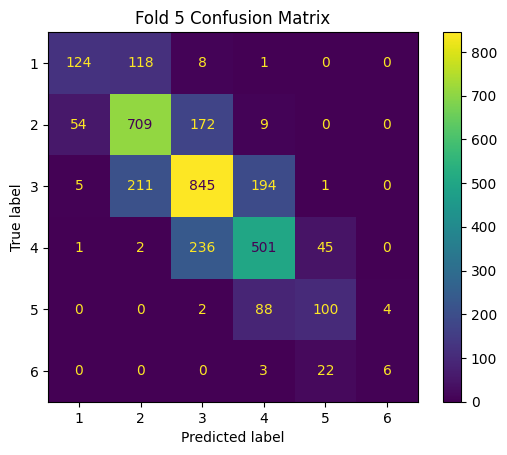

In [9]:
# Lists to store fold predictions
all_oof_predictions = []  # Out-of-fold predictions

# Train model on each fold
for fold in range(Config.num_folds):
    print(f"\n===== Training Fold {fold + 1}/{Config.num_folds} =====")
    
    # Get train and validation data for this fold
    train_fold = train_data[train_data['fold'] != fold]
    valid_fold = train_data[train_data['fold'] == fold].copy()
    
    # Add special tokens to tokenizer
    tokenizer = AutoTokenizer.from_pretrained(Config.model_path)
    # Add newline and double space tokens which are important for essay scoring
    tokenizer.add_tokens([AddedToken("\n", normalized=False)])
    tokenizer.add_tokens([AddedToken("  ", normalized=False)])
    
    # Tokenize data
    essay_tokenizer = EssayTokenizer(train_fold, valid_fold, tokenizer)
    tokenized_train, tokenized_valid, _ = essay_tokenizer.process()
    
    # Prepare model configuration
    config = AutoConfig.from_pretrained(Config.model_path)
    
    if Config.use_regression:
        # For regression, remove dropout and set num_labels to 1
        config.attention_probs_dropout_prob = 0.0
        config.hidden_dropout_prob = 0.0
        config.num_labels = 1
    else:
        config.num_labels = Config.num_classes
    
    # Initialize model with configuration
    model = AutoModelForSequenceClassification.from_pretrained(
        Config.model_path, 
        config=config
    )
    
    # Resize token embeddings to account for new tokens
    model.resize_token_embeddings(len(tokenizer))
    
    # Prepare data collator and metrics function
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    if Config.use_regression:
        compute_metrics = calculate_metrics_regression
    else:
        compute_metrics = calculate_metrics_classification
    
    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_valid,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    
    # Train the model
    trainer.train()
    
    # Evaluate model on validation set
    true_scores = valid_fold['score'].values
    raw_predictions = trainer.predict(tokenized_valid).predictions
    
    # Convert predictions to score format (1-6)
    if Config.use_regression:
        predicted_scores = raw_predictions.round(0) + 1
        valid_fold['predicted_score'] = raw_predictions + 1
    else:
        predicted_scores = raw_predictions.argmax(axis=1) + 1
        # Store probabilities for each class
        prob_columns = [f'prob_class_{i}' for i in range(Config.num_classes)]
        valid_fold[prob_columns] = raw_predictions
    
    # Plot confusion matrix
    cm = confusion_matrix(
        true_scores, 
        predicted_scores, 
        labels=list(range(1, 7))
    )
    cm_display = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=list(range(1, 7))
    )
    cm_display.plot()
    plt.title(f'Fold {fold + 1} Confusion Matrix')
    plt.show()
    
    # Save model and tokenizer
    fold_model_path = f'{Config.model_path.split("/")[-1]}_essay_scoring_fold_{fold}_v{Config.version}'
    trainer.save_model(fold_model_path)
    tokenizer.save_pretrained(fold_model_path)
    
    # Save validation predictions
    valid_fold.to_csv(f'validation_predictions_fold_{fold}_v{Config.version}.csv', index=False)
    all_oof_predictions.append(valid_fold)

# Combine all out-of-fold predictions
oof_predictions = pd.concat(all_oof_predictions)
oof_predictions.to_csv(f'all_validation_predictions_v{Config.version}.csv', index=False)

In [10]:
# Calculate overall cross-validation score
if Config.use_regression:
    overall_qwk = cohen_kappa_score(
        oof_predictions.score.values, 
        oof_predictions.predicted_score.values.clip(1, 6).round(0), 
        weights='quadratic'
    )
else:
    prob_columns = [f'prob_class_{i}' for i in range(Config.num_classes)]
    overall_qwk = cohen_kappa_score(
        oof_predictions.score.values, 
        oof_predictions[prob_columns].values.argmax(axis=1) + 1, 
        weights='quadratic'
    )

print(f'\nOverall Cross-Validation QWK Score: {overall_qwk:.4f}')


Overall Cross-Validation QWK Score: 0.8244


In [11]:
all_test_predictions = []

# Predict using each fold's model
for fold in range(Config.num_folds):
    fold_model_path = f'{Config.model_path.split("/")[-1]}_essay_scoring_fold_{fold}_v{Config.version}'
    
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(fold_model_path)
    model = AutoModelForSequenceClassification.from_pretrained(fold_model_path)
    
    # Tokenize test data
    test_tokenizer = EssayTokenizer(test_data, test_data, tokenizer)
    tokenized_test, _, _ = test_tokenizer.process()
    
    # Create a trainer just for inference
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        tokenizer=tokenizer,
    )
    
    # Get predictions
    test_predictions = trainer.predict(tokenized_test).predictions
    all_test_predictions.append(test_predictions)

# Average predictions from all folds
avg_test_predictions = np.mean(all_test_predictions, axis=0)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [12]:
if Config.use_regression:
    # For regression: clip predictions to 0-5, round to nearest integer, and add 1
    submission["score"] = avg_test_predictions.clip(0, 5).round(0) + 1
else:
    # For classification: get class with highest probability and add 1
    submission["score"] = avg_test_predictions.argmax(axis=1) + 1

# Ensure scores are integers
submission.score = submission.score.astype('int32')

# Save submission file
submission.to_csv('submission.csv', index=False)
print(f'Submission created with shape: {submission.shape}')

Submission created with shape: (3, 2)
